## Import necessary libraries

In [1]:
!pip install watermark

In [2]:
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# prevent scientific notations
pd.set_option('display.float_format', lambda x: '%.4f' % x)

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib,xgboost

Author: Ethen

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.33.0

numpy     : 1.21.6
pandas    : 1.3.5
sklearn   : 0.0
matplotlib: 3.5.3
xgboost   : 1.6.2



In [3]:
df = pd.read_csv('/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv')
print(df.shape)
df.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0000,2,2,1,24,2,2,-1,-1,...,0.0000,0.0000,0.0000,0.0000,689.0000,0.0000,0.0000,0.0000,0.0000,1
1,2,120000.0000,2,2,2,26,-1,2,0,0,...,3272.0000,3455.0000,3261.0000,0.0000,1000.0000,1000.0000,1000.0000,0.0000,2000.0000,1
2,3,90000.0000,2,2,2,34,0,0,0,0,...,14331.0000,14948.0000,15549.0000,1518.0000,1500.0000,1000.0000,1000.0000,1000.0000,5000.0000,0
3,4,50000.0000,2,2,1,37,0,0,0,0,...,28314.0000,28959.0000,29547.0000,2000.0000,2019.0000,1200.0000,1100.0000,1069.0000,1000.0000,0
4,5,50000.0000,1,2,1,57,-1,0,-1,0,...,20940.0000,19146.0000,19131.0000,2000.0000,36681.0000,10000.0000,9000.0000,689.0000,679.0000,0


In [4]:
id_cols = ['ID']
cat_cols = ['EDUCATION', 'SEX', 'MARRIAGE']
num_cols = [
    'LIMIT_BAL', 'AGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]
label_col = 'default.payment.next.month'

input_cols = num_cols + cat_cols

In [5]:
label_distr = np.round(np.bincount(df[label_col]) / df.shape[0], 3)
print('label distribution: ', label_distr)

label distribution:  [0.779 0.221]


In [6]:
test_size = 0.1
val_size = 0.3
random_state = 1234

df_train, df_test = train_test_split(
    df,
    test_size=test_size,
    random_state=random_state,
    stratify=df[label_col])

df_train, df_val = train_test_split(
    df_train,
    test_size=val_size,
    random_state=random_state,
    stratify=df_train[label_col])

print('train shape: ', df_train.shape)
print('validation shape: ', df_val.shape)
print('test shape: ', df_test.shape)

df_train.head()

train shape:  (18900, 25)
validation shape:  (8100, 25)
test shape:  (3000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
9256,9257,20000.0000,2,3,1,23,1,2,2,-2,...,0.0000,0.0000,0.0000,480.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1
23220,23221,150000.0000,2,3,2,35,-1,2,-1,2,...,1143.0000,163.0000,2036.0000,0.0000,2264.0000,0.0000,163.0000,2036.0000,0.0000,0
11074,11075,260000.0000,2,2,1,43,2,2,2,2,...,2500.0000,2500.0000,2500.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1
1583,1584,50000.0000,2,1,2,70,2,2,0,0,...,17793.0000,18224.0000,18612.0000,0.0000,2200.0000,700.0000,700.0000,674.0000,608.0000,0
8623,8624,390000.0000,2,2,1,45,1,-2,-2,-2,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3971.0000,1


In [7]:
# parameters chosen in an adhoc manner
xgb_params = {
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 30
}

xgb = XGBClassifier(**xgb_params)
xgb.fit(df_train[input_cols].values, df_train[label_col].values)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=30, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [8]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from typing import Dict, List, Tuple, Optional
from sklearn.utils import check_consistent_length, column_or_1d
from sklearn.calibration import calibration_curve


__all__ = [
    'compute_calibration_error',
    'create_binned_data',
    'get_bin_boundaries',
    'compute_binary_score',
    'compute_calibration_summary',
]


def compute_calibration_error(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    n_bins: int=15,
    round_digits: int=4) -> float:
    """
    Computes the calibration error for binary classification via binning
    data points into the specified number of bins. Samples with similar
    ``y_prob`` will be grouped into the same bin. The bin boundary is
    determined by having similar number of samples within each bin.
    Parameters
    ----------
    y_true : 1d ndarray
        Binary true targets.
    y_prob : 1d ndarray
        Raw probability/score of the positive class.
    n_bins : int, default 15
        A bigger bin number requires more data. In general,
        the larger the bin size, the closer the calibration error
        will be to the true calibration error.
    round_digits : int, default 4
        Round the calibration error metric.
    Returns
    -------
    calibration_error : float
        RMSE between the average positive label and predicted probability
        within each bin.
    """
    y_true = column_or_1d(y_true)
    y_prob = column_or_1d(y_prob)
    check_consistent_length(y_true, y_prob)

    binned_y_true, binned_y_prob = create_binned_data(y_true, y_prob, n_bins)

    # looping shouldn't be a source of bottleneck as n_bins should be a small number.
    bin_errors = 0.0
    for bin_y_true, bin_y_prob in zip(binned_y_true, binned_y_prob):
        avg_y_true = np.mean(bin_y_true)
        avg_y_score = np.mean(bin_y_prob)
        bin_error = (avg_y_score - avg_y_true) ** 2
        bin_errors += bin_error * len(bin_y_true)

    calibration_error = math.sqrt(bin_errors / len(y_true))
    return round(calibration_error, round_digits)


def create_binned_data(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    n_bins: int) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """
    Bin ``y_true`` and ``y_prob`` by distribution of the data.
    i.e. each bin will contain approximately an equal number of
    data points. Bins are sorted based on ascending order of ``y_prob``.
    Parameters
    ----------
    y_true : 1d ndarray
        Binary true targets.
    y_prob : 1d ndarray
        Raw probability/score of the positive class.
    n_bins : int, default 15
        A bigger bin number requires more data.
    Returns
    -------
    binned_y_true/binned_y_prob : 1d ndarray
        Each element in the list stores the data for that bin.
    """
    sorted_indices = np.argsort(y_prob)
    sorted_y_true = y_true[sorted_indices]
    sorted_y_prob = y_prob[sorted_indices]
    binned_y_true = np.array_split(sorted_y_true, n_bins)
    binned_y_prob = np.array_split(sorted_y_prob, n_bins)
    return binned_y_true, binned_y_prob


def get_bin_boundaries(binned_y_prob: List[np.ndarray]) -> np.ndarray:
    """
    Given ``binned_y_prob`` from ``create_binned_data`` get the
    boundaries for each bin.
    Parameters
    ----------
    binned_y_prob : list
        Each element in the list stores the data for that bin.
    Returns
    -------
    bins : 1d ndarray
        Boundaries for each bin.
    """
    bins = []
    for i in range(len(binned_y_prob) - 1):
        last_prob = binned_y_prob[i][-1]
        next_first_prob = binned_y_prob[i + 1][0]
        bins.append((last_prob + next_first_prob) / 2.0)

    bins.append(1.0)
    return np.array(bins)


def compute_binary_score(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    round_digits: int=4) -> Dict[str, float]:
    """
    Compute various evaluation metrics for binary classification.
    Including auc, precision, recall, f1, log loss, brier score. The
    threshold for precision and recall numbers are based on the one
    that gives the best f1 score.
    Parameters
    ----------
    y_true : 1d ndarray
        Binary true targets.
    y_prob : 1d ndarray
        Raw probability/score of the positive class.
    round_digits : int, default 4
        Round the evaluation metric.
    Returns
    -------
    metrics_dict : dict
        Metrics are stored in key value pair. ::
        {
            'auc': 0.82,
            'precision': 0.56,
            'recall': 0.61,
            'f1': 0.59,
            'log_loss': 0.42,
            'brier': 0.12
        }
    """
    auc = round(metrics.roc_auc_score(y_true, y_prob), round_digits)
    log_loss = round(metrics.log_loss(y_true, y_prob), round_digits)
    brier_score = round(metrics.brier_score_loss(y_true, y_prob), round_digits)

    precision, recall, threshold = metrics.precision_recall_curve(y_true, y_prob)
    f1 = 2 * (precision * recall) / (precision + recall)

    mask = ~np.isnan(f1)
    f1 = f1[mask]
    precision = precision[mask]
    recall = recall[mask]

    best_index = np.argmax(f1)
    precision = round(precision[best_index], round_digits)
    recall = round(recall[best_index], round_digits)
    f1 = round(f1[best_index], round_digits)
    return {
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'log_loss': log_loss,
        'brier': brier_score
    }


def compute_calibration_summary(
    eval_dict: Dict[str, pd.DataFrame],
    label_col: str='label',
    score_col: str='score',
    n_bins: int=15,
    strategy: str='quantile',
    round_digits: int=4,
    show: bool=True,
    save_plot_path: Optional[str]=None) -> pd.DataFrame:
    """
    Plots the calibration curve and computes the summary statistics for the model.
    Parameters
    ----------
    eval_dict : dict
        We can evaluate multiple calibration model's performance in one go. The key
        is the model name used to distinguish different calibration model, the value
        is the dataframe that stores the binary true targets and the predicted score
        for the positive class.
    label_col : str
        Column name for the dataframe in ``eval_dict`` that stores the binary true targets.
    score_col : str
        Column name for the dataframe in ``eval_dict`` that stores the predicted score.
    n_bins : int, default 15
        Number of bins to discretize the calibration curve plot and calibration error statistics.
        A bigger number requires more data, but will be closer to the true calibration error.
    strategy : {'uniform', 'quantile'}, default 'quantile'
        Strategy used to define the boundary of the bins.
        - uniform: The bins have identical widths.
        - quantile: The bins have the same number of samples and depend on the predicted score.
    round_digits : default 4
        Round the evaluation metric.
    show : bool, default True
        Whether to show the plots on the console or jupyter notebook.
    save_plot_path : str, default None
        Path where we'll store the calibration plot. None means it will not save the plot.
    Returns
    -------
    df_metrics : pd.DataFrame
        Corresponding metrics for all the input dataframe.
    """

    fig, (ax1, ax2) = plt.subplots(2)

    # estimator_metrics stores list of dict, e.g.
    # [{'auc': 0.776, 'name': 'xgb'}]
    estimator_metrics = []
    for name, df_eval in eval_dict.items():
        prob_true, prob_pred = calibration_curve(
            df_eval[label_col],
            df_eval[score_col],
            n_bins=n_bins,
            strategy=strategy)

        calibration_error = compute_calibration_error(
            df_eval[label_col], df_eval[score_col], n_bins, round_digits)
        metrics_dict = compute_binary_score(df_eval[label_col], df_eval[score_col], round_digits)
        metrics_dict['calibration_error'] = calibration_error
        metrics_dict['name'] = name
        estimator_metrics.append(metrics_dict)

        ax1.plot(prob_pred, prob_true, 's-', label=name)
        ax2.hist(df_eval[score_col], range=(0, 1), bins=n_bins, label=name, histtype='step', lw=2)

    ax1.plot([0, 1], [0, 1], 'k:', label='perfect')

    ax1.set_xlabel('Fraction of positives (Predicted)')
    ax1.set_ylabel('Fraction of positives (Actual)')
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc='upper left', ncol=2)
    ax1.set_title('Calibration Plots (Reliability Curve)')

    ax2.set_xlabel('Predicted scores')
    ax2.set_ylabel('Count')
    ax2.set_title('Histogram of Predicted Scores')
    ax2.legend(loc='upper right', ncol=2)

    plt.tight_layout()
    if show:
        plt.show()

    if save_plot_path is not None:
        save_dir = os.path.dirname(save_plot_path)
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        fig.savefig(save_plot_path, dpi=300, bbox_inches='tight')

    plt.close(fig)

    df_metrics = pd.DataFrame(estimator_metrics)
    return df_metrics

In [9]:
estimators = {
    'xgb': xgb
}
df_groups = {
    'train': df_train,
    'val': df_val
}

estimator_metrics = []
for name, estimator in estimators.items():
    for df_name, df_group in df_groups.items():
        y_prob = estimator.predict_proba(df_group[input_cols].values)[:, 1]
        # compute various binary classification metrics
        metric_dict = compute_binary_score(df_group[label_col], y_prob)
        metric_dict['name'] = name + '_' + df_name
        estimator_metrics.append(metric_dict)

df_metrics = pd.DataFrame(estimator_metrics)
df_metrics

,auc,precision,recall,f1,log_loss,brier,name
0,0.8293,0.5667,0.6163,0.5904,0.3958,0.1213,xgb_train
1,0.7872,0.5177,0.5954,0.5539,0.4257,0.1330,xgb_val


Measuring Calibration
We'll first discuss how do we measure whether a model is well-calibrated or not. The main idea here is to first discretize our model predictions into  M  interval bins, and calculate the average fraction of positives and predicted probability of each bin. Here, the number of bin is configurable, and samples that have similar predicted score will fall into the same bin.

Let  Bm  be the set of samples whose predicted probability falls into interval  Im=(m−1M,mM] . The fraction of positives for  Bm  can be computed by:

pos(Bm)=1|Bm|∑i∈Bmyi
 
Where  yi  is the true class label for sample  i  (assuming in the binary classification setting 1 denotes a positive class and 0 otherwise). On the other hand, the predicted probability within bin  Bm  is defined as:

prob(Bm)=1|Bm|∑i∈Bmpi^
 
Where  pi^  is the predicted probability for sample  i . Given the two terms, fraction of positives and predicted probability within each bin, we can either build a calibration curve to visualize the amount of miscalibration or directly compute a summary statistics.

Calibration Curve or also known as a Reliability Diagram. For each bin, the mean predicted probability,  prob(Bm) , is plotted against the fraction of positive cases for that bin,  pos(Bm) . If the model is well-calibrated, then the points will fall near the diagonal line, and any deviation from that diagonal line in the visualization depicts some level of miscalibration with our model.

Expected Calibrator Error (ECE) is one commonly used summary statistic that measures the difference between the expected probability and fraction of positives.

ECE=∑m=1M|Bm|n(prob(Bm)−pos(Bm))2−−−−−−−−−−−−−−−−−−−−−−−−−−⎷
 
Where  n  is the total number of samples. Here the expected calibration error is measured by the RMSE (Root Meas Squared Error) between  prob(Bm)  and  pos(Bm) . If we wish to have a metric that is less sensitive to outliers, we could also switch to MAE (Mean Absolute Error).

We'll now take a look at these concepts in action.

In [10]:
# extract the validation and test true label and predicted probability,
# as we are working with binary classification in this use case, we can
# extract the predicted probability for the positive class
labels_val = df_val[label_col].values
xgb_pred_val = xgb.predict_proba(df_val[input_cols].values)[:, 1]

labels_test = df_test[label_col].values
xgb_pred_test = xgb.predict_proba(df_test[input_cols].values)[:, 1]

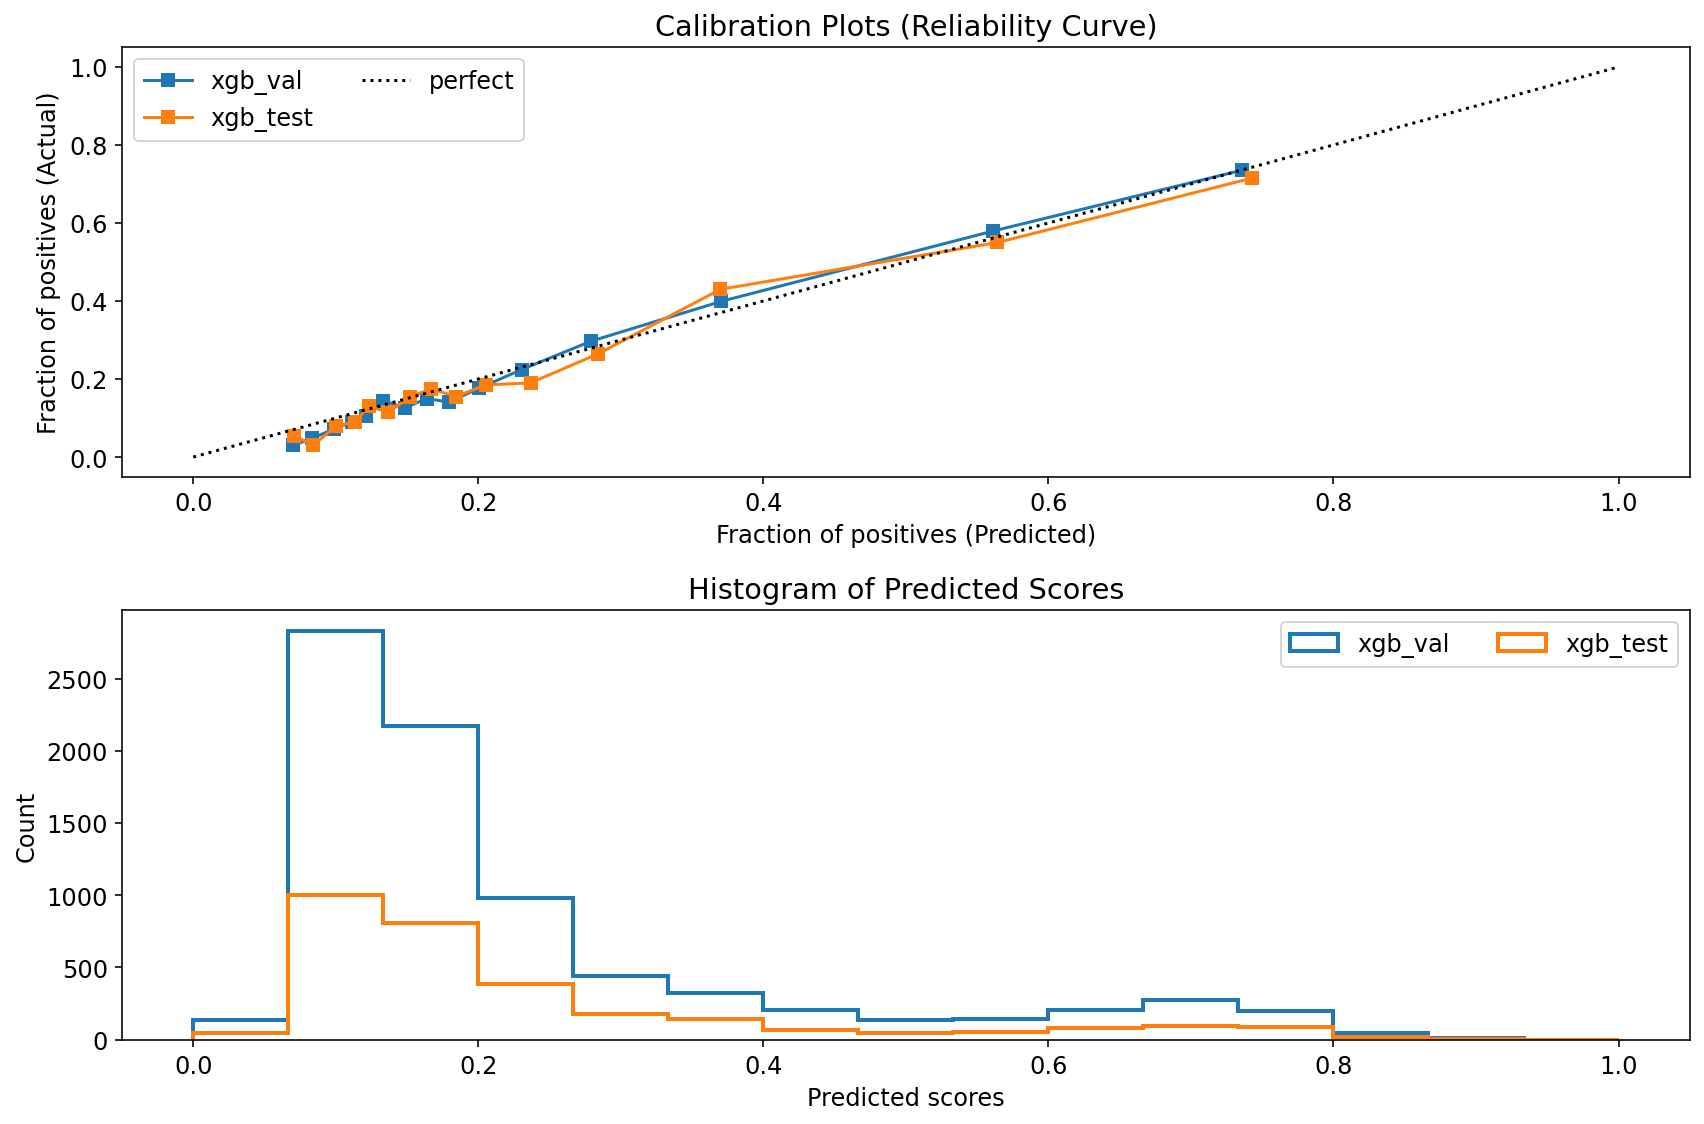

,auc,precision,recall,f1,log_loss,brier,calibration_error,name
0,0.7872,0.5177,0.5954,0.5539,0.4257,0.1330,0.0240,xgb_val
1,0.7739,0.5423,0.5602,0.5511,0.4355,0.1369,0.0296,xgb_test


In [11]:
# link the label and probability into a dataframe
score_col = 'score'
df_xgb_eval_val = pd.DataFrame({
    label_col: labels_val,
    score_col: xgb_pred_val
})
df_xgb_eval_test = pd.DataFrame({
    label_col: labels_test,
    score_col: xgb_pred_test
})

# key to the dictionary is for giving the result
# a descriptive name
eval_dict = {
    'xgb_val': df_xgb_eval_val,
    'xgb_test': df_xgb_eval_test
}

# change default style figure and font size
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 12

n_bins = 15
df_result = compute_calibration_summary(eval_dict, label_col, score_col, n_bins=n_bins)
df_result

In [12]:
from sklearn.calibration import IsotonicRegression

In [13]:
isotonic = IsotonicRegression(out_of_bounds='clip',
                              y_min=xgb_pred_val.min(),
                              y_max=xgb_pred_val.max())
isotonic.fit(xgb_pred_val, labels_val)
isotonic_probs = isotonic.predict(xgb_pred_test)
isotonic_probs

array([0.22972973, 0.14263076, 0.05276734, ..., 0.13581395, 0.11445783,
       0.36842105], dtype=float32)

In [14]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator
#from calibration_module.utils import create_binned_data, get_bin_boundaries


__all__ = [
    'HistogramCalibrator',
    'PlattCalibrator',
    'PlattHistogramCalibrator'
]


class HistogramCalibrator(BaseEstimator):
    """
    Bins the data based on equal size interval (each bin contains approximately
    equal size of samples).
    Parameters
    ----------
    n_bins : int, default 15
        A bigger bin number requires more data. In general,
        the larger the bin size, the closer the calibration error
        will be to the true calibration error.
    Attributes
    ----------
    bins_ : 1d ndarray
        Boundaries for each bin.
    bins_score_ : 1d ndarray
        Calibration score for each bin.
    """

    def __init__(self, n_bins: int=15):
        self.n_bins = n_bins

    def fit(self, y_prob: np.ndarray, y_true: np.ndarray):
        """
        Learns the bin boundaries and calibration score for each bin.
        Parameters
        ----------
        y_prob : 1d ndarray
            Raw probability/score of the positive class.
        y_true : 1d ndarray
            Binary true targets.
        Returns
        -------
        self
        """
        binned_y_true, binned_y_prob = create_binned_data(y_true, y_prob, self.n_bins)
        self.bins_ = get_bin_boundaries(binned_y_prob)
        self.bins_score_ = np.array([np.mean(value) for value in binned_y_true])
        return self

    def predict(self, y_prob: np.ndarray) -> np.ndarray:
        """
        Predicts the calibrated probability.
        Parameters
        ----------
        y_prob : 1d ndarray
            Raw probability/score of the positive class.
        Returns
        -------
        y_calibrated_prob : 1d ndarray
            Calibrated probability.
        """
        indices = np.searchsorted(self.bins_, y_prob)
        return self.bins_score_[indices]


class PlattCalibrator(BaseEstimator):
    """
    Boils down to applying a Logistic Regression.
    Parameters
    ----------
    log_odds : bool, default True
        Logistic Regression assumes a linear relationship between its input
        and the log-odds of the class probabilities. Converting the probability
        to log-odds scale typically improves performance.
    Attributes
    ----------
    coef_ : ndarray of shape (1,)
        Binary logistic regression's coefficient.
    intercept_ : ndarray of shape (1,)
        Binary logistic regression's intercept.
    """

    def __init__(self, log_odds: bool=True):
        self.log_odds = log_odds

    def fit(self, y_prob: np.ndarray, y_true: np.ndarray):
        """
        Learns the logistic regression weights.
        Parameters
        ----------
        y_prob : 1d ndarray
            Raw probability/score of the positive class.
        y_true : 1d ndarray
            Binary true targets.
        Returns
        -------
        self
        """
        self.fit_predict(y_prob, y_true)
        return self

    @staticmethod
    def _convert_to_log_odds(y_prob: np.ndarray) -> np.ndarray:
        eps = 1e-12
        y_prob = np.clip(y_prob, eps, 1 - eps)
        y_prob = np.log(y_prob / (1 - y_prob))
        return y_prob

    def predict(self, y_prob: np.ndarray) -> np.ndarray:
        """
        Predicts the calibrated probability.
        Parameters
        ----------
        y_prob : 1d ndarray
            Raw probability/score of the positive class.
        Returns
        -------
        y_calibrated_prob : 1d ndarray
            Calibrated probability.
        """
        if self.log_odds:
            y_prob = self._convert_to_log_odds(y_prob)

        output = self._transform(y_prob)
        return output

    def _transform(self, y_prob: np.ndarray) -> np.ndarray:
        output = y_prob * self.coef_[0] + self.intercept_
        output = 1 / (1 + np.exp(-output))
        return output

    def fit_predict(self, y_prob: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        """
        Chain the .fit and .predict step together.
        Parameters
        ----------
        y_prob : 1d ndarray
            Raw probability/score of the positive class.
        y_true : 1d ndarray
            Binary true targets.
        Returns
        -------
        y_calibrated_prob : 1d ndarray
            Calibrated probability. 
        """
        if self.log_odds:
            y_prob = self._convert_to_log_odds(y_prob)

        # the class expects 2d ndarray as input features
        logistic = LogisticRegression(C=1e10, solver='lbfgs')
        logistic.fit(y_prob.reshape(-1, 1), y_true)
        self.coef_ = logistic.coef_[0]
        self.intercept_ = logistic.intercept_

        y_calibrated_prob = self._transform(y_prob)
        return y_calibrated_prob


class PlattHistogramCalibrator(PlattCalibrator):
    """
    Boils down to first applying a Logistic Regression then perform
    histogram binning.
    Parameters
    ----------
    log_odds : bool, default True
        Logistic Regression assumes a linear relationship between its input
        and the log-odds of the class probabilities. Converting the probability
        to log-odds scale typically improves performance.
    n_bins : int, default 15
        A bigger bin number requires more data. In general,
        the larger the bin size, the closer the calibration error
        will be to the true calibration error.
    Attributes
    ----------
    coef_ : ndarray of shape (1,)
        Binary logistic regresion's coefficient.
    intercept_ : ndarray of shape (1,)
        Binary logistic regression's intercept.
    bins_ : 1d ndarray
        Boundaries for each bin.
    bins_score_ : 1d ndarray
        Calibration score for each bin.
    """

    def __init__(self, log_odds: bool=True, n_bins: int=15):
        super().__init__(log_odds)
        self.n_bins = n_bins

    def fit(self, y_prob: np.ndarray, y_true: np.ndarray):
        """
        Learns the logistic regression weights and the
        bin boundaries and calibration score for each bin.
        Parameters
        ----------
        y_prob : 1d ndarray
            Raw probability/score of the positive class.
        y_true : 1d ndarray
            Binary true targets.
        Returns
        -------
        self
        """
        y_prob_platt = super().fit_predict(y_prob, y_true)
        binned_y_true, binned_y_prob = create_binned_data(y_true, y_prob_platt, self.n_bins)
        self.bins_ = get_bin_boundaries(binned_y_prob)
        self.bins_score_ = np.array([np.mean(value) for value in binned_y_prob])
        return self

    def predict(self, y_prob: np.ndarray) -> np.ndarray:
        """
        Predicts the calibrated probability.
        Parameters
        ----------
        y_prob : 1d ndarray
            Raw probability/score of the positive class.
        Returns
        -------
        y_calibrated_prob : 1d ndarray
            Calibrated probability.
        """
        y_prob_platt = super().predict(y_prob)
        indices = np.searchsorted(self.bins_, y_prob_platt)
        return self.bins_score_[indices]

In [15]:
histogram = HistogramCalibrator(n_bins=n_bins)
histogram.fit(xgb_pred_val, labels_val)
histogram_probs = histogram.predict(xgb_pred_test)
histogram_probs

array([0.22407407, 0.14074074, 0.02962963, ..., 0.12592593, 0.10555556,
       0.39814815])

In [16]:
platt = PlattCalibrator(log_odds=True)
platt.fit(xgb_pred_val, labels_val)
platt_probs = platt.predict(xgb_pred_test)
platt_probs

array([0.2116992 , 0.16321564, 0.05074317, ..., 0.12652918, 0.10286036,
       0.35680279])

In [17]:
platt_histogram = PlattHistogramCalibrator(n_bins=n_bins, log_odds=True)
platt_histogram.fit(xgb_pred_val, labels_val)
platt_histogram_probs = platt_histogram.predict(xgb_pred_test)
platt_histogram_probs

array([0.21283885, 0.15907912, 0.05334451, ..., 0.12737967, 0.10104891,
       0.3687527 ])

## Calibration Model Evaluation

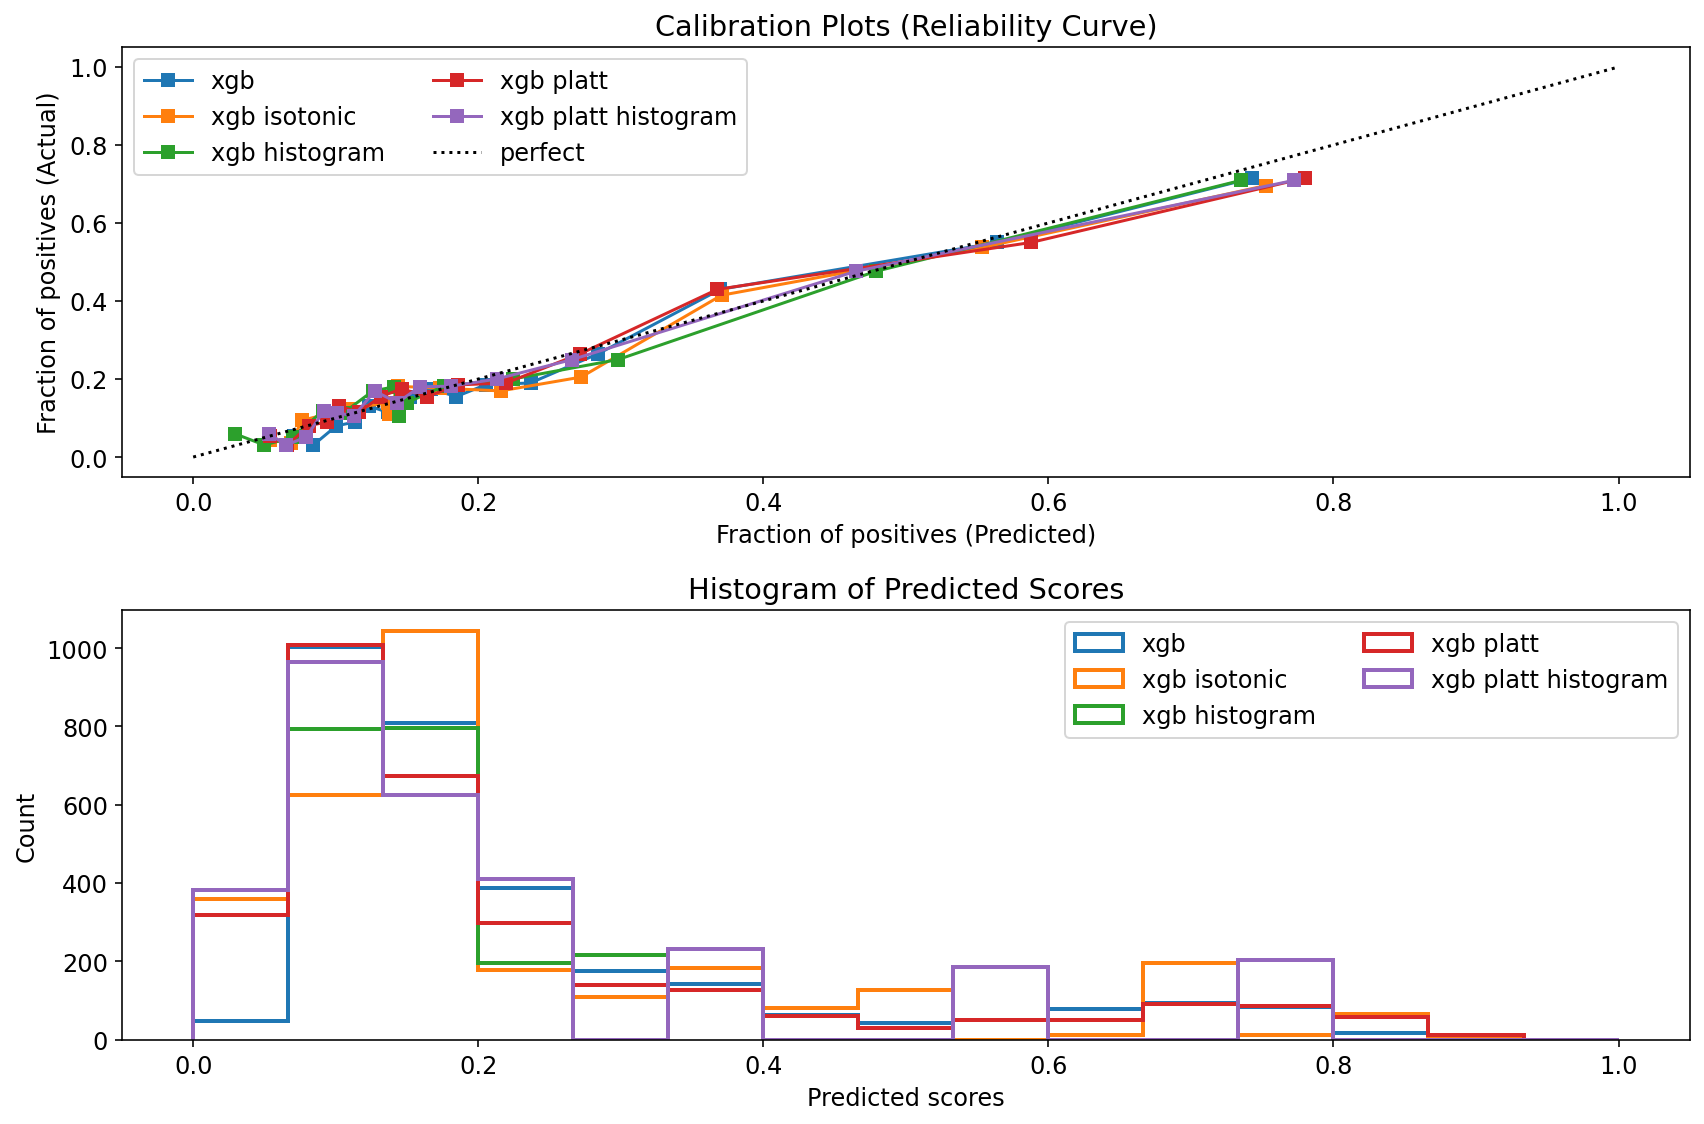

,auc,precision,recall,f1,log_loss,brier,calibration_error,name
4,0.7706,0.5525,0.5151,0.5331,0.4376,0.1379,0.0243,xgb platt histogram
2,0.7665,0.5525,0.5151,0.5331,0.4379,0.1379,0.0258,xgb histogram
0,0.7739,0.5423,0.5602,0.5511,0.4355,0.1369,0.0296,xgb
3,0.7739,0.5423,0.5602,0.5511,0.4349,0.1369,0.0304,xgb platt
1,0.7736,0.5423,0.5602,0.5511,0.4342,0.1367,0.0369,xgb isotonic


In [18]:
score_col = 'score'
df_xgb_eval_test = pd.DataFrame({
    label_col: labels_test,
    score_col: xgb_pred_test
})
df_xgb_isotonic_eval_test = pd.DataFrame({
    label_col: labels_test,
    score_col: isotonic_probs + 1e-3
})
df_xgb_platt_eval_test = pd.DataFrame({
    label_col: labels_test,
    score_col: platt_probs
})
df_xgb_platt_histogram_eval_test = pd.DataFrame({
    label_col: labels_test,
    score_col: platt_histogram_probs
})
df_xgb_histogram_eval_test = pd.DataFrame({
    label_col: labels_test,
    score_col: histogram_probs
})


eval_dict = {
    'xgb': df_xgb_eval_test,
    'xgb isotonic': df_xgb_isotonic_eval_test,
    'xgb histogram': df_xgb_histogram_eval_test,
    'xgb platt': df_xgb_platt_eval_test,
    'xgb platt histogram': df_xgb_platt_histogram_eval_test
}

df_result = compute_calibration_summary(eval_dict, label_col, score_col, n_bins=n_bins)
df_result.sort_values('calibration_error')

In [19]:
platt = PlattCalibrator(log_odds=False)
platt.fit(xgb_pred_val, labels_val)
platt_probs = platt.predict(xgb_pred_test)
platt_probs

array([0.1854087 , 0.14956946, 0.08383791, ..., 0.12562479, 0.11153563,
       0.3220031 ])

In [20]:
platt_histogram = PlattHistogramCalibrator(n_bins=n_bins, log_odds=False)
platt_histogram.fit(xgb_pred_val, labels_val)
platt_histogram_probs = platt_histogram.predict(xgb_pred_test)
platt_histogram_probs

array([0.18644158, 0.14676159, 0.08514048, ..., 0.12617081, 0.11050533,
       0.33625734])

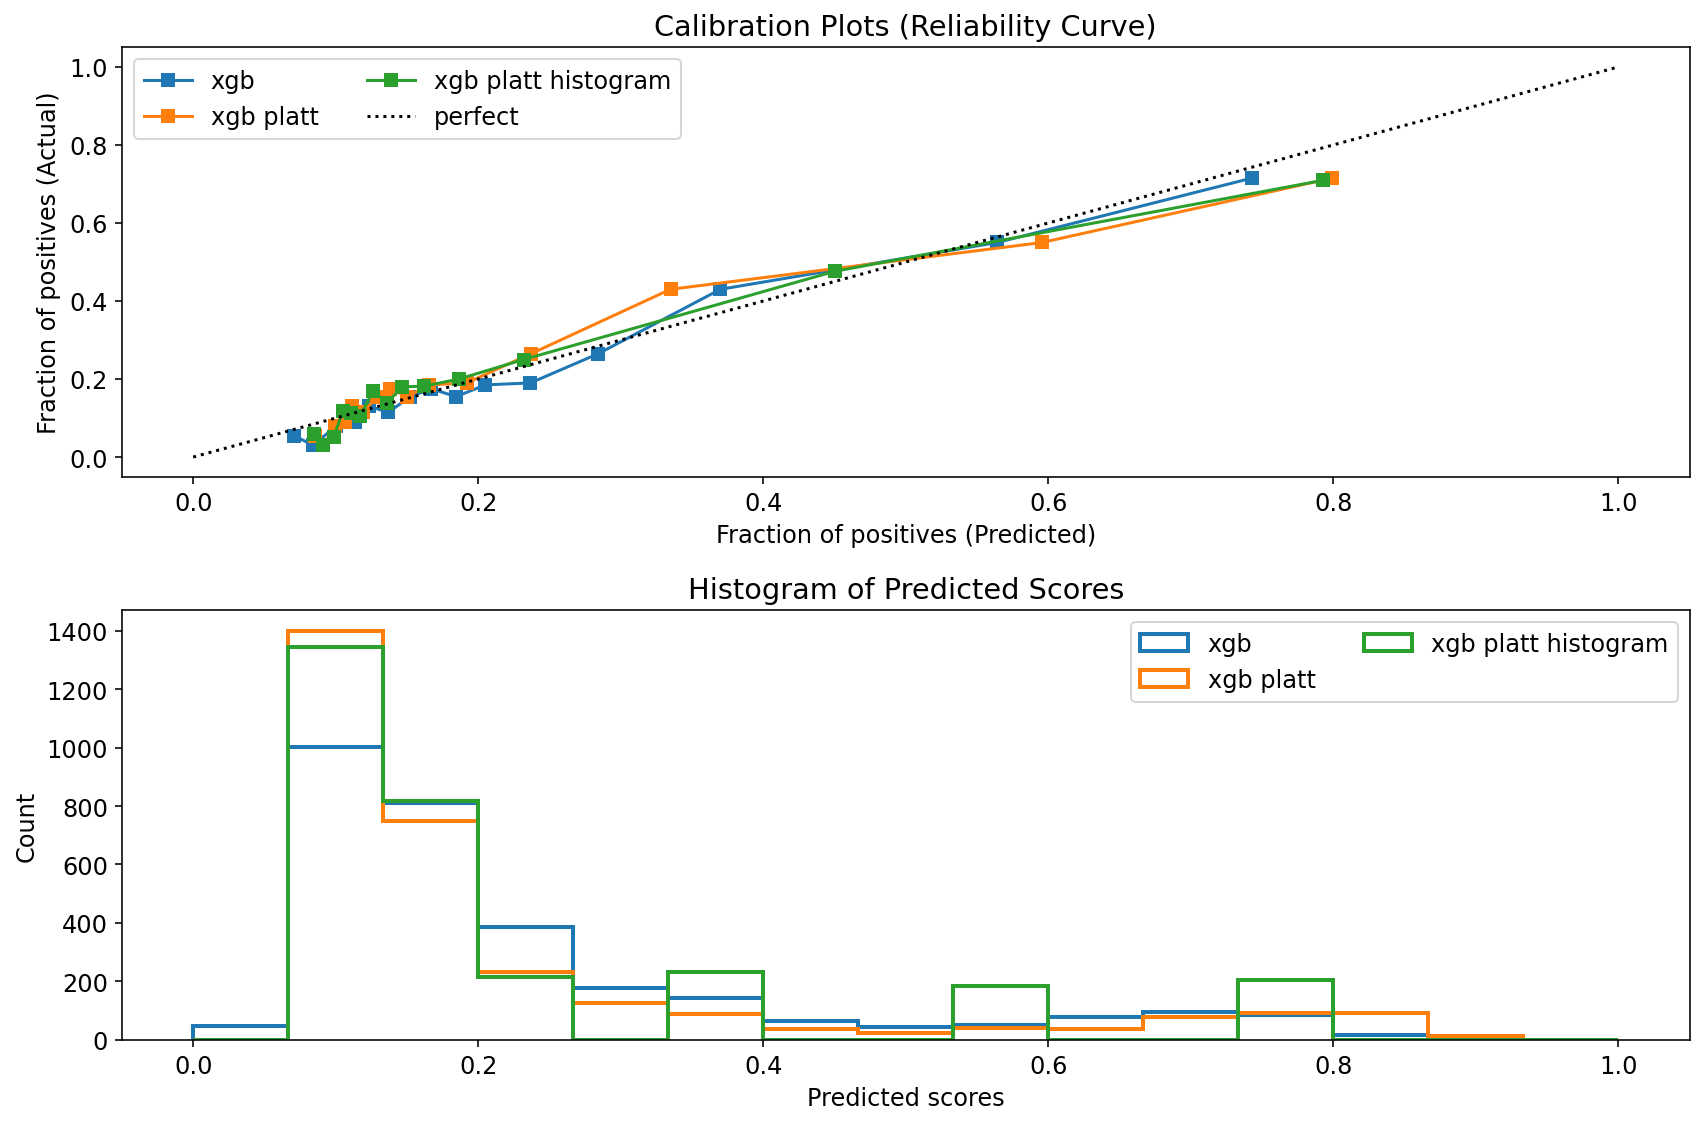

,auc,precision,recall,f1,log_loss,brier,calibration_error,name
0,0.7739,0.5423,0.5602,0.5511,0.4355,0.1369,0.0296,xgb
2,0.7706,0.5525,0.5151,0.5331,0.4408,0.1388,0.0363,xgb platt histogram
1,0.7739,0.5423,0.5602,0.5511,0.4385,0.1379,0.0425,xgb platt


In [21]:
df_xgb_platt_eval_test = pd.DataFrame({
    label_col: labels_test,
    score_col: platt_probs
})
df_xgb_platt_histogram_eval_test = pd.DataFrame({
    label_col: labels_test,
    score_col: platt_histogram_probs
})

eval_dict = {
    'xgb': df_xgb_eval_test,
    'xgb platt': df_xgb_platt_eval_test,
    'xgb platt histogram': df_xgb_platt_histogram_eval_test
}

df_result = compute_calibration_summary(eval_dict, label_col, score_col, n_bins=n_bins)
df_result.sort_values('calibration_error')

https://ethen8181.github.io/machine-learning/model_selection/prob_calibration/prob_calibration.html